In [1]:
import seaborn as sns
import pylab as plot
from fastai.imports import *
from fastai.tabular import *
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from IPython.display import display
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

params = {
    'axes.labelsize': 'large',
    'xtick.labelsize': 'x-large',
    'legend.fontsize': 20,
    'figure.dpi': 150,
    'figure.figsize': [10, 6]
}
plot.rcParams.update(params)

## Load the train & test data

In [2]:
train_raw=pd.read_csv('train.csv',low_memory=False)
test_raw=pd.read_csv('test.csv',low_memory=False)
train_raw.shape, test_raw.shape

((891, 12), (418, 11))

## Check if data is loaded properly

In [3]:
train_raw.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Data exploration

In [4]:
data = train_raw
data['Died']= 1 - data['Survived']
data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Died
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208,0.616162
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429,0.486592
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400,0.000000
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200,1.000000
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000,1.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200,1.000000


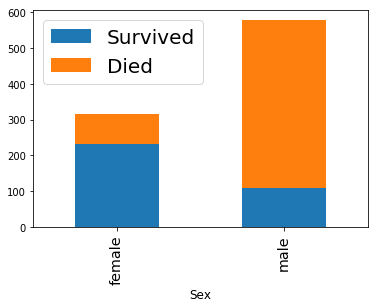

In [5]:
data.groupby('Sex').agg('sum')[['Survived','Died']].plot(kind='bar',stacked=True)

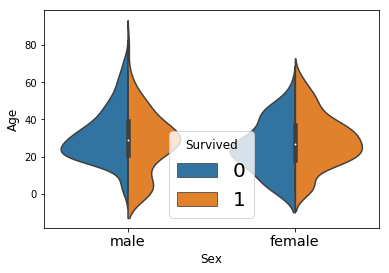

In [6]:
sns.violinplot(x='Sex', y='Age', hue='Survived',data=data,split=True)

## Check the Fare ticket of each passagener and see how it impact the survival

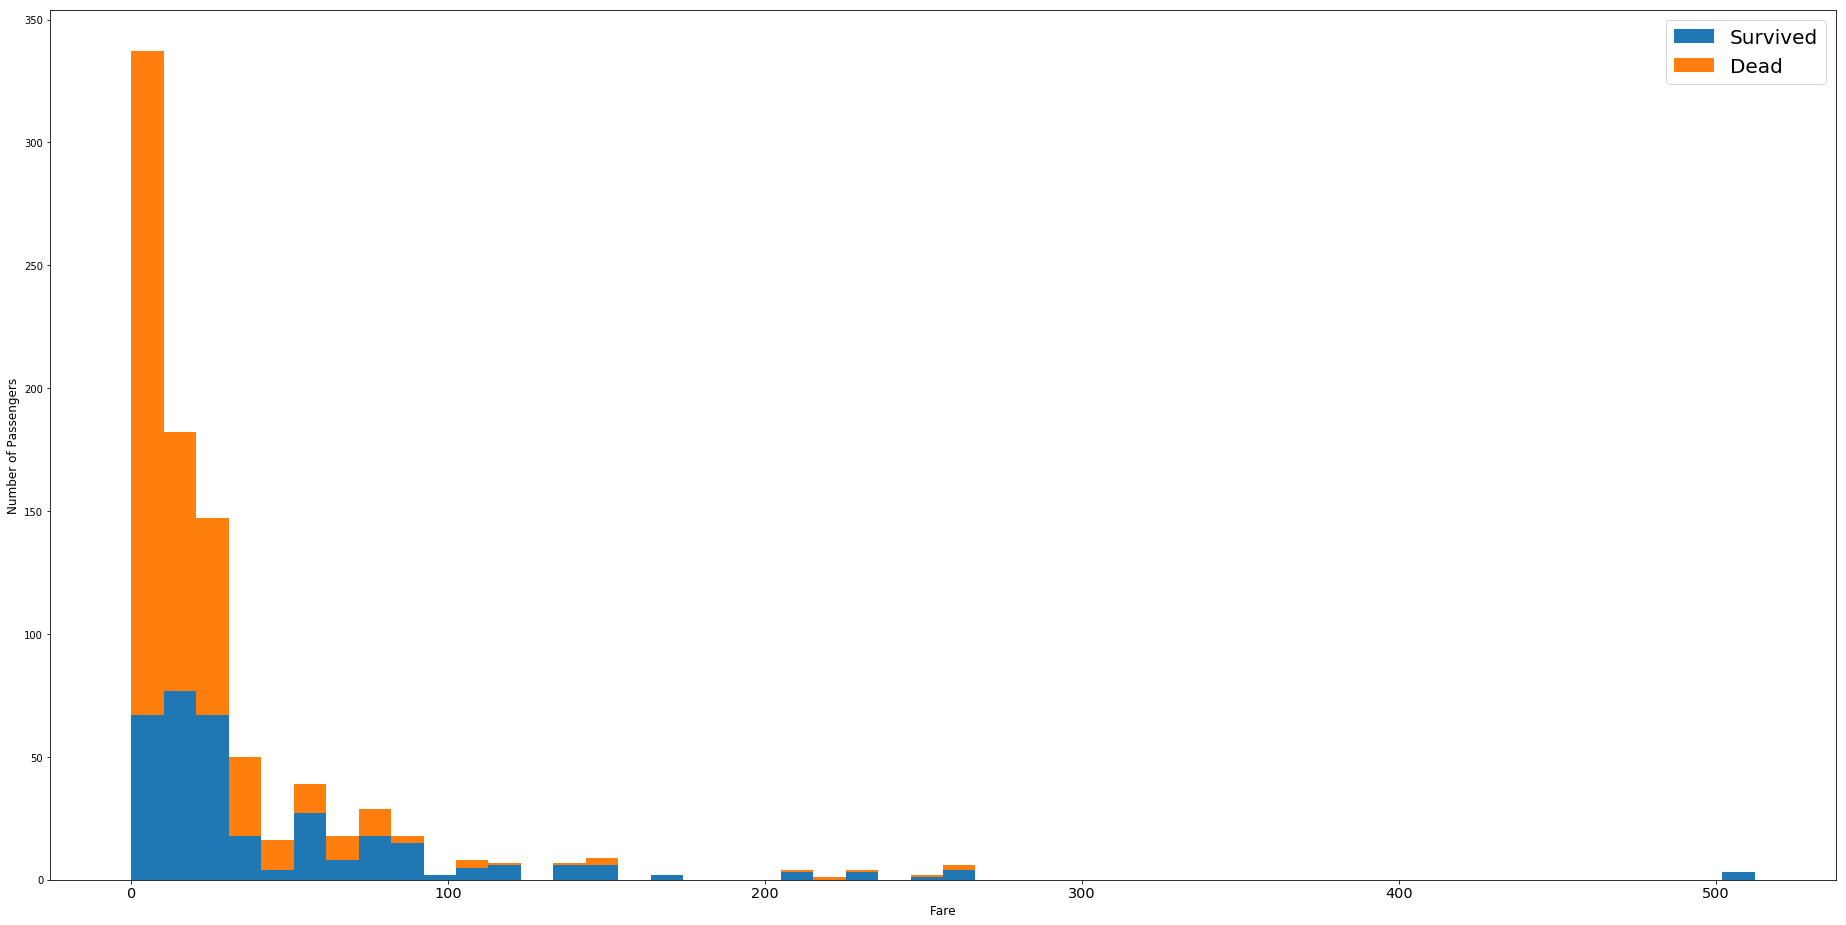

In [7]:
figure = plt.figure(figsize=(32,16))
plt.hist([data[data['Survived'] == 1]['Fare'], data[data['Survived'] == 0]['Fare']], stacked=True, bins = 50, label = ['Survived','Dead'])
plt.xlabel('Fare')
plt.ylabel('Number of Passengers')
plt.legend();

## Combine age, fare and survival in one chart

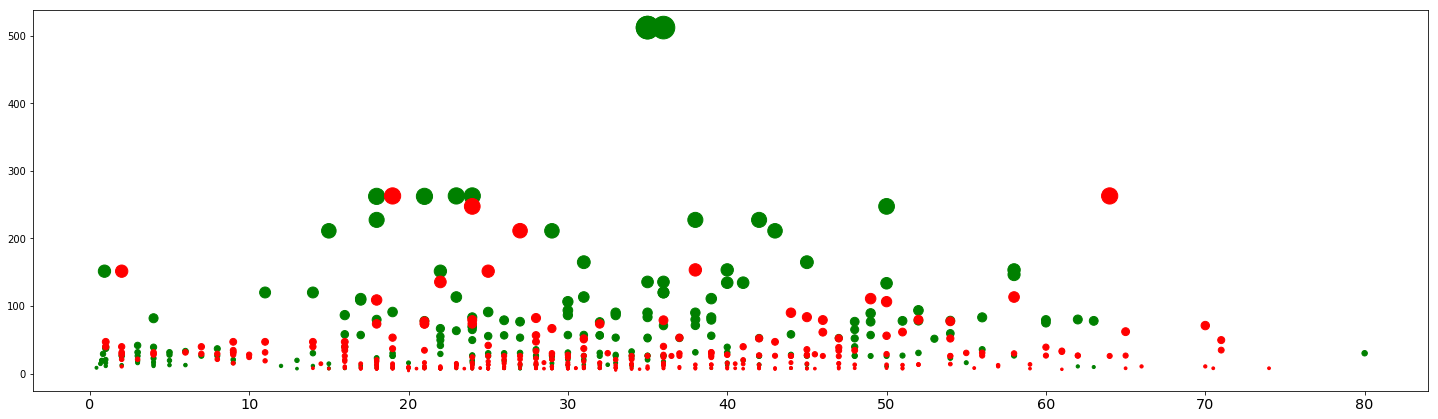

In [8]:
plt.figure(figsize=(25, 7))
ax = plt.subplot()

ax.scatter(data[data['Survived'] == 1]['Age'], data[data['Survived'] == 1]['Fare'], c='green', s=data[data['Survived'] == 1]['Fare'])
ax.scatter(data[data['Survived'] == 0]['Age'], data[data['Survived'] == 0]['Fare'], c='red', s=data[data['Survived'] == 0]['Fare']);

## Ticket fare vs class

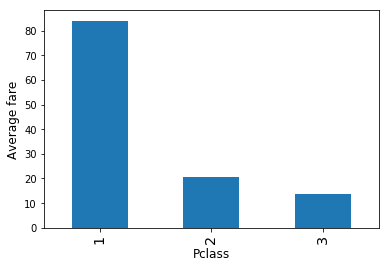

In [9]:
ax = plt.subplot()
ax.set_ylabel('Average fare')
data.groupby('Pclass').mean()['Fare'].plot(kind='bar',ax=ax)

# Feature engineering

## Combining the test and train data to prepare the data for modeling

In [10]:
x_train = train_raw.drop(['Survived'],1)
y_train = train_raw['Survived']
x_test = test_raw
df_combined = x_train.append(x_test)
df_combined.shape

def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

display_all(df_combined.tail().T)

/home/adulu/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


,413,414,415,416,417
Age,NaN,39,38.5,NaN,NaN
Cabin,NaN,C105,NaN,NaN,NaN
Died,NaN,NaN,NaN,NaN,NaN
Embarked,S,C,S,S,C
Fare,8.05,108.9,7.25,8.05,22.3583
Name,"Spector, Mr. Woolf","Oliva y Ocana, Dona. Fermina","Saether, Mr. Simon Sivertsen","Ware, Mr. Frederick","Peter, Master. Michael J"
Parch,0,0,0,0,1
PassengerId,1305,1306,1307,1308,1309
Pclass,3,1,3,3,3
Sex,male,female,male,male,male


### Train model

In [11]:
import pandas.api.types as ptypes
def train_cats(df):
    
    for n,c in df.items():
        if ptypes.is_string_dtype(c): df[n] = c.astype('category').cat.as_ordered()
    
train_cats(df_combined)

### Check missing data

In [12]:
display_all(df_combined.isnull().sum().sort_index()/len(df_combined))

Age            0.200917
Cabin          0.774637
Died           0.319328
Embarked       0.001528
Fare           0.000764
Name           0.000000
Parch          0.000000
PassengerId    0.000000
Pclass         0.000000
Sex            0.000000
SibSp          0.000000
Ticket         0.000000
dtype: float64

### Change dataframes to numeric fields

In [13]:
def proc_df(df, y_fld=None, skip_flds=None, ignore_flds=None, do_scale=False, na_dict=None, preproc_fn=None, max_n_cat=None, subset=None, mapper=None):
    if not ignore_flds: ignore_flds=[]
    if not skip_flds: skip_flds=[]
    if subset: df = get_sample(df,subset)
    else: df = df.copy()
    ignored_flds = df.loc[:, ignore_flds]
    df.drop(ignore_flds, axis=1, inplace=True)
    if preproc_fn: preproc_fn(df)
    if y_fld is None: y = None
    else:
        if not is_numeric_dtype(df[y_fld]): df[y_fld] = pd.Categorical(df[y_fld]).codes
        y = df[y_fld].values
        skip_flds += [y_fld]
    df.drop(skip_flds, axis=1, inplace=True)

    if na_dict is None: na_dict = {}
    else: na_dict = na_dict.copy()
    na_dict_initial = na_dict.copy()
    for n,c in df.items(): na_dict = fix_missing(df, c, n, na_dict)
    if len(na_dict_initial.keys()) > 0:
        df.drop([a + '_na' for a in list(set(na_dict.keys()) - set(na_dict_initial.keys()))], axis=1, inplace=True)
    if do_scale: mapper = scale_vars(df, mapper)
    for n,c in df.items(): numericalize(df, c, n, max_n_cat)
    df = pd.get_dummies(df, dummy_na=True)
    df = pd.concat([ignored_flds, df], axis=1)
    res = [df, y, na_dict]
    if do_scale: res = res + [mapper]
    return res

def fix_missing(df, col, name, na_dict):
    if ptypes.is_numeric_dtype(col):
        if pd.isnull(col).sum() or (name in na_dict):
            df[name+'_na'] = pd.isnull(col)
            filler = na_dict[name] if name in na_dict else col.median()
            df[name] = col.fillna(filler)
            na_dict[name] = filler
    return na_dict

def numericalize(df, col, name, max_n_cat):
    if not ptypes.is_numeric_dtype(col) and ( max_n_cat is None or len(col.cat.categories)>max_n_cat):
        df[name] = pd.Categorical(col).codes+1
        
df, y, nas = proc_df(df_combined, y_fld=None, ignore_flds=['Age','Name','Embarked','Cabin','Parch', 'SibSp'])
df.head()

,Age,Name,Embarked,Cabin,Parch,SibSp,Died,Fare,PassengerId,Pclass,Sex,Ticket,Died_na,Fare_na
0,22.0,"Braund, Mr. Owen Harris",S,NaN,0,1,1.0,7.2500,1,3,2,721,False,False
1,38.0,"Cumings, Mrs. John Bradley (Florence Briggs Th...",C,C85,0,1,0.0,71.2833,2,1,1,817,False,False
2,26.0,"Heikkinen, Miss. Laina",S,NaN,0,0,0.0,7.9250,3,3,1,915,False,False
3,35.0,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",S,C123,0,1,0.0,53.1000,4,1,1,66,False,False
4,35.0,"Allen, Mr. William Henry",S,NaN,0,0,1.0,8.0500,5,3,2,650,False,False


### Process family feature

In [14]:
def process_family():
    
    global df
    df['FamilySize'] = df['Parch'] + df['SibSp'] + 1
    
    df['Singleton'] = df['FamilySize'].map(lambda s: 1 if s == 1 else 0)
    df['SmallFamily'] = df['FamilySize'].map(lambda s: 1 if 2 <= s <= 4 else 0)
    df['LargeFamily'] = df['FamilySize'].map(lambda s: 1 if 5 <= s else 0)    
    return df

df = process_family()

### Process embarked

In [15]:
def process_embarked():
    global df
    
    df.Embarked.fillna('S', inplace=True)
    
    df_dummies = pd.get_dummies(df['Embarked'], prefix='Embarked')
    df = pd.concat([df, df_dummies], axis=1)
    df.drop('Embarked', axis=1, inplace=True)
    
    return df

df = process_embarked()

### Process cabin

In [16]:
def process_cabin():
    global df    
    df.Cabin.fillna('T', inplace=True)
    
    df['Cabin'] = df['Cabin'].map(lambda c: c[0])
    
    cabin_dummies = pd.get_dummies(df['Cabin'], prefix='Cabin')    
    df = pd.concat([df, cabin_dummies], axis=1)

    df.drop('Cabin', axis=1, inplace=True)
    return df

df = process_cabin()


### Get title from name

In [17]:
titles = set()
for name in df['Name']:
    titles.add(name.split(',')[1].split('.')[0].strip())
    
    
Title_Dictionary = {
    "Capt": "Officer",
    "Col": "Officer",
    "Major": "Officer",
    "Jonkheer": "Royalty",
    "Don": "Royalty",
    "Sir" : "Royalty",
    "Dr": "Officer",
    "Rev": "Officer",
    "the Countess":"Royalty",
    "Mme": "Mrs",
    "Mlle": "Miss",
    "Ms": "Mrs",
    "Mr" : "Mr",
    "Mrs" : "Mrs",
    "Miss" : "Miss",
    "Master" : "Master",
    "Lady" : "Royalty"
}

def get_titles():
    df['Title'] = df['Name'].map(lambda name:name.split(',')[1].split('.')[0].strip())
    
    
    df['Title'] = df.Title.map(Title_Dictionary)
    return df

df = get_titles()
df.head()

,Age,Name,Parch,SibSp,Died,Fare,PassengerId,Pclass,Sex,Ticket,...,Embarked_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Title
0,22.0,"Braund, Mr. Owen Harris",0,1,1.0,7.2500,1,3,2,721,...,1,0,0,0,0,0,0,0,1,Mr
1,38.0,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1,0.0,71.2833,2,1,1,817,...,0,0,0,1,0,0,0,0,0,Mrs
2,26.0,"Heikkinen, Miss. Laina",0,0,0.0,7.9250,3,3,1,915,...,1,0,0,0,0,0,0,0,1,Miss
3,35.0,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,1,0.0,53.1000,4,1,1,66,...,1,0,0,1,0,0,0,0,0,Mrs
4,35.0,"Allen, Mr. William Henry",0,0,1.0,8.0500,5,3,2,650,...,1,0,0,0,0,0,0,0,1,Mr


### Process Age

In [18]:
grouped_train = df.groupby(['Sex','Pclass','Title'])
grouped_median_train = grouped_train.median()
grouped_median_train = grouped_median_train.reset_index()[['Sex', 'Pclass', 'Title', 'Age']]
grouped_median_train.head()
df.head()

,Age,Name,Parch,SibSp,Died,Fare,PassengerId,Pclass,Sex,Ticket,...,Embarked_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Title
0,22.0,"Braund, Mr. Owen Harris",0,1,1.0,7.2500,1,3,2,721,...,1,0,0,0,0,0,0,0,1,Mr
1,38.0,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1,0.0,71.2833,2,1,1,817,...,0,0,0,1,0,0,0,0,0,Mrs
2,26.0,"Heikkinen, Miss. Laina",0,0,0.0,7.9250,3,3,1,915,...,1,0,0,0,0,0,0,0,1,Miss
3,35.0,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,1,0.0,53.1000,4,1,1,66,...,1,0,0,1,0,0,0,0,0,Mrs
4,35.0,"Allen, Mr. William Henry",0,0,1.0,8.0500,5,3,2,650,...,1,0,0,0,0,0,0,0,1,Mr


### Impute age values & process age

In [19]:
def fill_age(row):
    condition = (
        (grouped_median_train['Sex'] == row['Sex']) & 
        (grouped_median_train['Title'] == row['Title']) & 
        (grouped_median_train['Pclass'] == row['Pclass'])
    ) 
    if np.isnan(grouped_median_train[condition]['Age'].values[0]):
        print('true')
        condition = (
            (grouped_median_train['Sex'] == row['Sex']) & 
            (grouped_median_train['Pclass'] == row['Pclass'])
        )

    return grouped_median_train[condition]['Age'].values[0]


def process_age():
    global df
    df['Age'] = df.apply(lambda row: fill_age(row) if np.isnan(row['Age']) else row['Age'], axis=1)
    return df
df = process_age()

### Check for missing values

In [20]:
display_all(df.isnull().sum().sort_index()/len(df))

Age            0.000000
Cabin_A        0.000000
Cabin_B        0.000000
Cabin_C        0.000000
Cabin_D        0.000000
Cabin_E        0.000000
Cabin_F        0.000000
Cabin_G        0.000000
Cabin_T        0.000000
Died           0.000000
Died_na        0.000000
Embarked_C     0.000000
Embarked_Q     0.000000
Embarked_S     0.000000
FamilySize     0.000000
Fare           0.000000
Fare_na        0.000000
LargeFamily    0.000000
Name           0.000000
Parch          0.000000
PassengerId    0.000000
Pclass         0.000000
Sex            0.000000
SibSp          0.000000
Singleton      0.000000
SmallFamily    0.000000
Ticket         0.000000
Title          0.000764
dtype: float64

### Process names

In [21]:
def process_names():
    global df
    df.drop('Name', axis=1, inplace=True)
    
    titles_dummies = pd.get_dummies(df['Title'], prefix='Title')
    df = pd.concat([df, titles_dummies], axis=1)
    
    df.drop('Title', axis=1, inplace=True)
    
    return df
df = process_names()

### Check null values

In [22]:
df.head()
display_all(df.isnull().sum().sort_index()/len(df))

Age              0.0
Cabin_A          0.0
Cabin_B          0.0
Cabin_C          0.0
Cabin_D          0.0
Cabin_E          0.0
Cabin_F          0.0
Cabin_G          0.0
Cabin_T          0.0
Died             0.0
Died_na          0.0
Embarked_C       0.0
Embarked_Q       0.0
Embarked_S       0.0
FamilySize       0.0
Fare             0.0
Fare_na          0.0
LargeFamily      0.0
Parch            0.0
PassengerId      0.0
Pclass           0.0
Sex              0.0
SibSp            0.0
Singleton        0.0
SmallFamily      0.0
Ticket           0.0
Title_Master     0.0
Title_Miss       0.0
Title_Mr         0.0
Title_Mrs        0.0
Title_Officer    0.0
Title_Royalty    0.0
dtype: float64

## Build and Train model

### Separate train and test data

In [23]:
x_train = df[:891].copy()
x_test = df[891:].copy()
x_train.shape,x_test.shape


((891, 32), (418, 32))

### Split data into valid set

In [24]:
def split_vals(a,n): return a[:n], a[n:]
valid_count = 60
n_trn = len(x_train)-valid_count
x_train1, x_valid1 = split_vals(x_train, n_trn)
y_train1, y_valid1 = split_vals(y_train, n_trn)
x_train1.shape,y_train1.shape,x_valid1.shape,y_valid1.shape

((831, 32), (831,), (60, 32), (60,))

### Train model

In [25]:
m = RandomForestClassifier(n_estimators=180,min_samples_leaf=3,max_features=0.5,n_jobs=-1)
m.fit(x_train1,y_train1)
m.score(x_train1,y_train1)

1.0

### Model Evaluation

In [26]:
y_predict = m.predict(x_valid1)
from sklearn.metrics import accuracy_score
accuracy_score(y_valid1,y_predict)

1.0

In [27]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_valid1,y_predict))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        38
           1       1.00      1.00      1.00        22

   micro avg       1.00      1.00      1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60



### Confusion matrix

In [28]:
print(confusion_matrix(y_valid1,y_predict))

[[38  0]
 [ 0 22]]


### Feature importance

In [29]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
).sort_values('imp', ascending=False)

fi = rf_feat_importance(m, x_train1); fi[:10]

,cols,imp
3,Died,0.828673
28,Title_Mr,0.060940
7,Sex,0.053318
6,Pclass,0.013740
27,Title_Miss,0.006693
4,Fare,0.005879
29,Title_Mrs,0.005157
8,Ticket,0.005033
11,FamilySize,0.004402
0,Age,0.004205


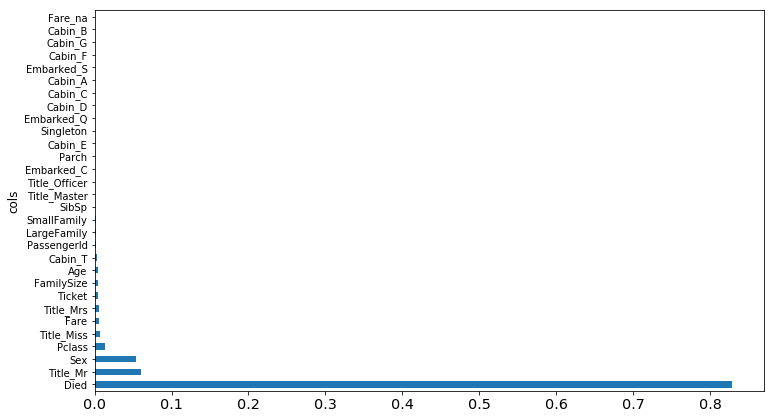

In [30]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)
plot_fi(fi[:30]);

### Imporant features

In [31]:
to_keep = fi[fi.imp>0.01].cols; len(to_keep)
to_keep

3         Died
28    Title_Mr
7          Sex
6       Pclass
Name: cols, dtype: object

## Final Model

In [32]:
x_train = x_train[to_keep]
m = RandomForestClassifier(n_estimators=200,min_samples_leaf=3,max_features=0.5,n_jobs=-1)
m.fit(x_train,y_train)
m.score(x_train,y_train)

1.0

### Model on test data

In [33]:
x_test = x_test[to_keep]
output = m.predict(x_test).astype(int)
output.size

418

### Save predictions to file

In [34]:
aux = pd.read_csv('test.csv',low_memory=False)
df_output = pd.DataFrame()
df_output['PassengerId'] = aux['PassengerId']
df_output['Survived'] = output
df_output[['PassengerId','Survived']].to_csv('titanic_fastai.csv', index=False)